In [1]:
import sys
sys.path.insert(1, '/t0-analysis/CKA-similarity')

import numpy as np
from CKA import CKA
from scipy.spatial import distance

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

from utils import load_hidden_representations_from_hdf5, read_templates_from_file

In [2]:
# params
log_dir = "/logfiles"
models = ["bigscience-T0_3B", "google-t5-xl-lm-adapt"]
module = "decoder"
task = "rte"

In [3]:
# assertions
assert module == "decoder"
assert task == "rte"

## Prompts

In [4]:
df = read_templates_from_file(f"/t0-analysis/prompts/{task}/all.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_prompt.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_target_yes_no.csv")
display(df)

,name,template,category,includes_targets,targets,target_ids,shuffle
0,gpt_3_yes_no_with_targets,{premise} Question: {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
1,mnli_crowdsource_with_targets,"{premise} Using only the above description and what you know about the world, is ""{hypothesis}"" definitely correct? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
2,based_on_previous_passage_with_targets,"{premise} Based on the previous passage, is it true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
3,infer_with_targets,"Suppose {premise} Can we infer that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
4,follow_with_targets,Given that {premise} Does it follow that {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
5,imply_with_targets,"{premise} Question: Does this imply that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
6,guaranteed_with_targets,"Given {premise} Is it guaranteed true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
7,justified_with_targets,"{premise} Are we justified in saying that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
8,must_be_true_with_targets,"Given that {premise} Therefore, it must be true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
9,should_assume_with_targets,"Given {premise} Should we assume that ""{hypothesis}"" is true? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False


## Comput CKA

In [5]:
use_pattern = [
    "gpt_3_yes_no_with_targets",
    "mnli_crowdsource_with_targets",
    "based_on_previous_passage_with_targets",
    "infer_with_targets",
    "follow_with_targets",
    "imply_with_targets",
    "guaranteed_with_targets",
    "justified_with_targets",
    "must_be_true_with_targets",
    "should_assume_with_targets",
    "gpt_3_true_false_with_targets",
    "gpt_3_cat_dog_with_targets",
    "gpt_3_cat_dog_with_targets_yes_no",
    "gpt_3_yes_no_without_targets",
    "words_appear_with_targets",
    "similar_words_with_targets",
    "start_with_the_with_targets",
    "same_meaning_with_targets",
    "paraphrase_with_targets",
    "paraphrase_r_with_targets",
    "summarize_with_targets",
    "inflection_with_targets",
    "null_pattern_with_targets",
    "null_pattern_r_with_targets",
    "null_pattern_without_targets",
    "null_pattern_r_without_targets",
    "premise_only_with_targets",
    "premise_only_without_targets",
    "hypothesis_only_with_targets",
    "hypothesis_only_without_targets",
]

In [16]:
representations = {}

# for layer in tqdm(range(0, 1), desc='layers'):
# for layer in tqdm(range(0, 5), desc='layers'):
for layer in tqdm(range(0, 25), desc='layers'):
# for layer in tqdm(range(22, 25), desc='layers'):
    layer_key = f"{module}-{layer}"
    file_names, prompt_names = [], []

    if layer_key not in representations:
        representations[layer_key] = {}

    for model in models:
        for _, row in df.iterrows():
            if row['name'] in use_pattern:
                file_name = f"{task}/{model}/{module}/{row['name']}/hidden_represenations_t0_layer{layer}_avg.hdf5"
                file_names.append(file_name)
                prompt_names.append(row['name'])
                if file_name not in representations[layer_key]:
                    # load hidden representations from hdf5 file
                    representations[layer_key][file_name] = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name), silent=True)
    
    

layers: 100%|██████████| 25/25 [01:58<00:00,  4.74s/it]


In [17]:
representations.keys()

dict_keys(['decoder-0', 'decoder-1', 'decoder-2', 'decoder-3', 'decoder-4', 'decoder-5', 'decoder-6', 'decoder-7', 'decoder-8', 'decoder-9', 'decoder-10', 'decoder-11', 'decoder-12', 'decoder-13', 'decoder-14', 'decoder-15', 'decoder-16', 'decoder-17', 'decoder-18', 'decoder-19', 'decoder-20', 'decoder-21', 'decoder-22', 'decoder-23', 'decoder-24'])

In [18]:
# len(representations['decoder-0'].keys())

In [19]:
# Compute pairwise cosine similarity for every layer
cosim_scores_layers = {}
for layer in tqdm(list(representations.keys())[:], desc="layers"):
    cosim_scores = []
    for pattern1 in representations[layer].keys():
        cosim_scores_pattern1 = []
        for pattern2 in representations[layer].keys():
            h1 = representations[layer][pattern1]
            h2 = representations[layer][pattern2]
            cosim_avg = 0.0
            for idx in range(len(h1)):
                cosim_avg += 1 - distance.cosine(h1[idx], h2[idx])
            cosim_avg = cosim_avg / len(h1)
            cosim_scores_pattern1.append(cosim_avg)
        cosim_scores.append(cosim_scores_pattern1)
    cosim_scores = np.asarray(cosim_scores)
    cosim_scores_layers[layer] = cosim_scores

layers: 100%|██████████| 25/25 [18:26<00:00, 44.26s/it]


In [20]:
cosim_scores_layers.keys()

dict_keys(['decoder-0', 'decoder-1', 'decoder-2', 'decoder-3', 'decoder-4', 'decoder-5', 'decoder-6', 'decoder-7', 'decoder-8', 'decoder-9', 'decoder-10', 'decoder-11', 'decoder-12', 'decoder-13', 'decoder-14', 'decoder-15', 'decoder-16', 'decoder-17', 'decoder-18', 'decoder-19', 'decoder-20', 'decoder-21', 'decoder-22', 'decoder-23', 'decoder-24'])

In [21]:
# cosim_scores_layers['encoder-0'].shape

In [22]:
len(use_pattern)

30

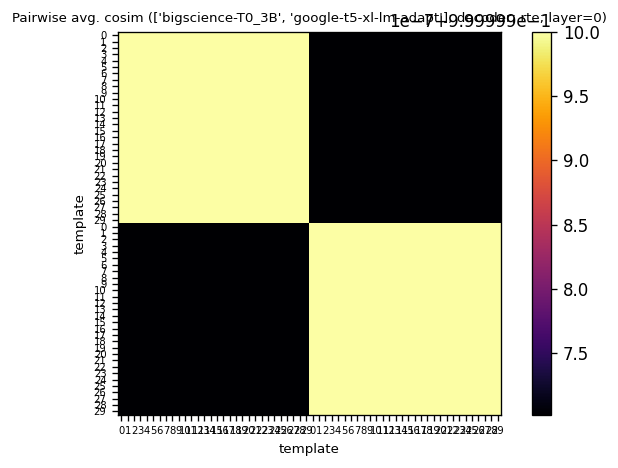

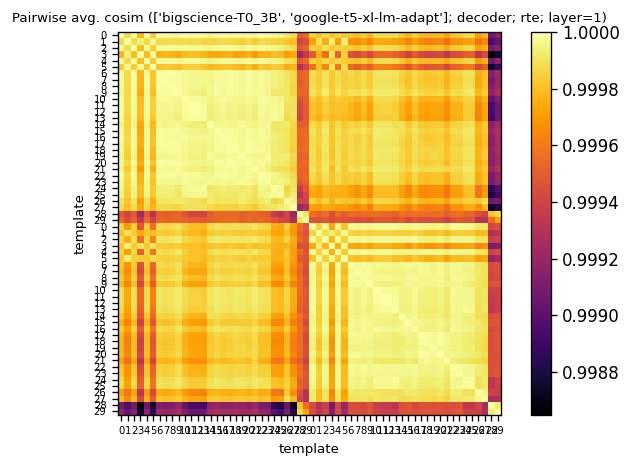

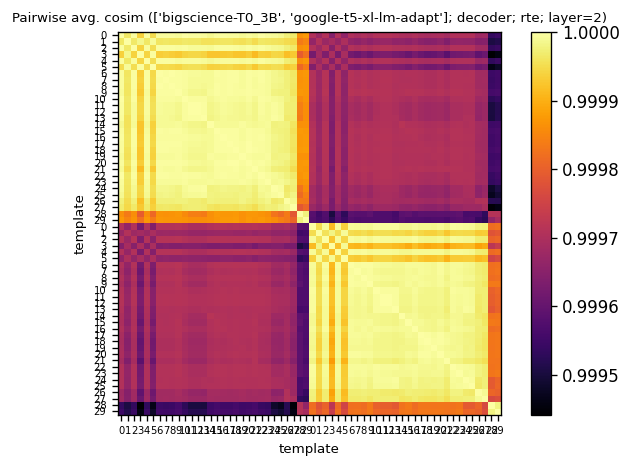

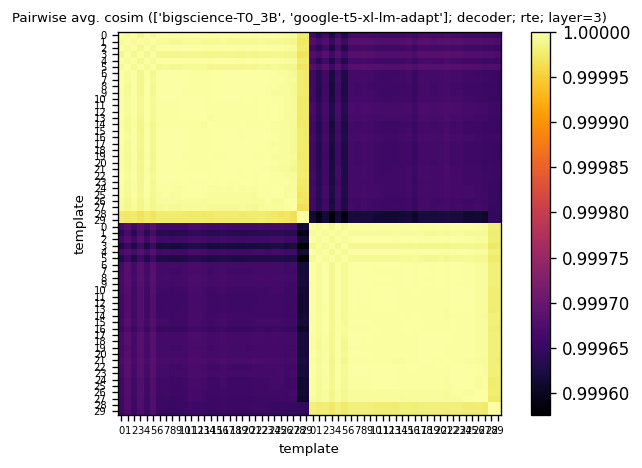

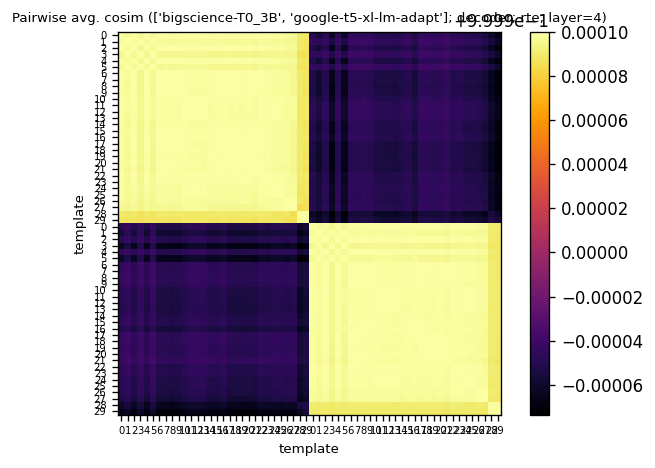

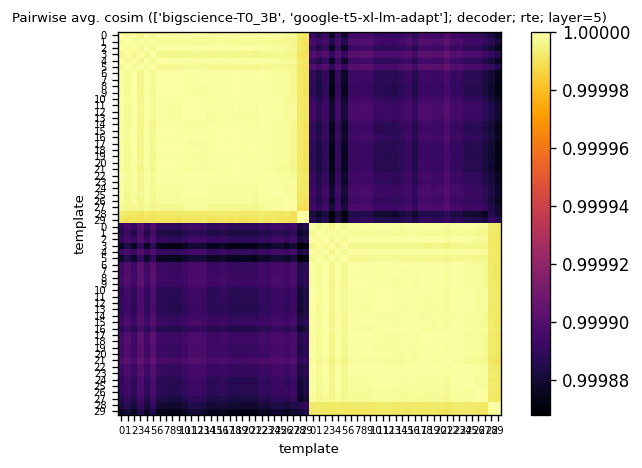

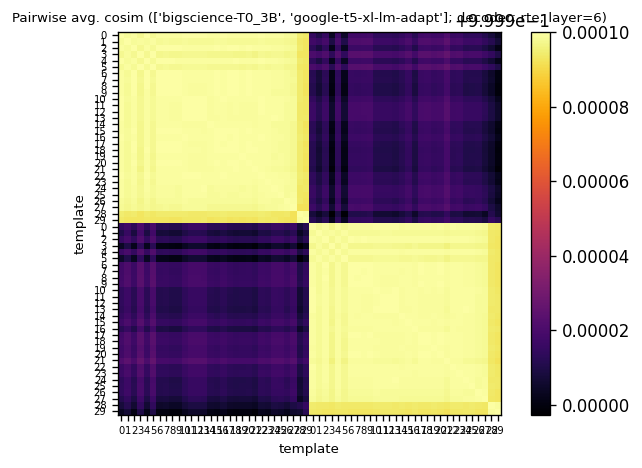

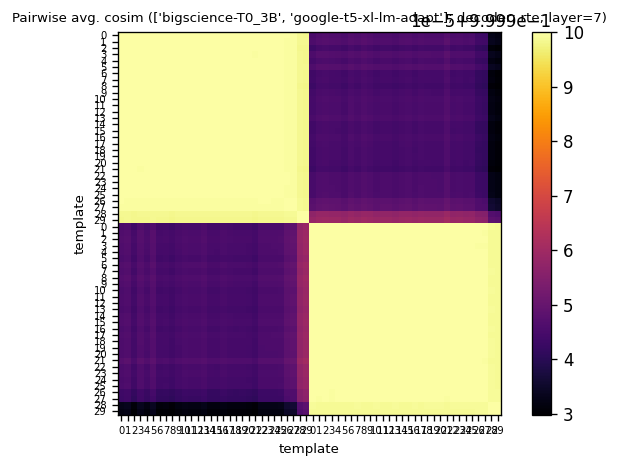

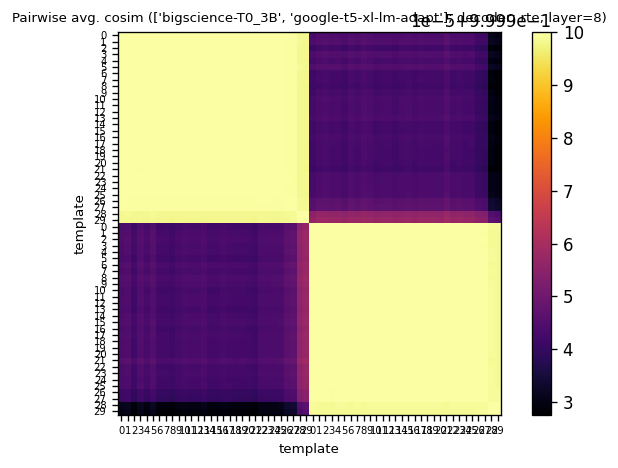

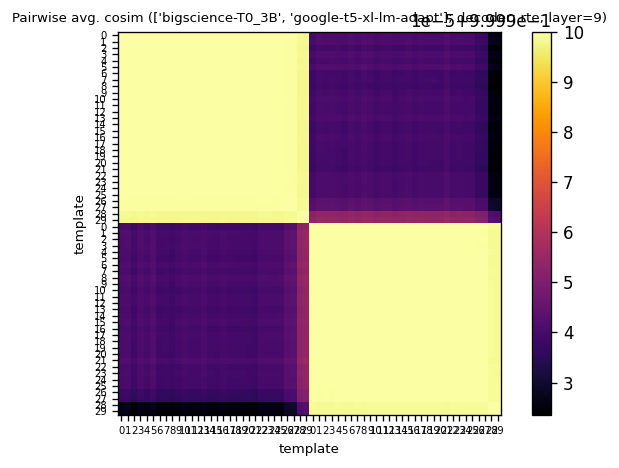

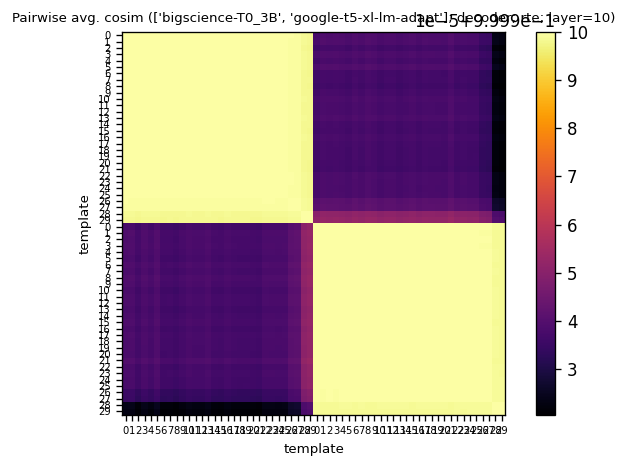

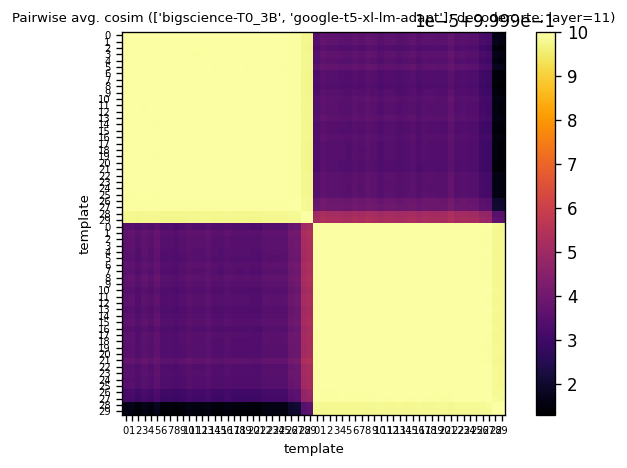

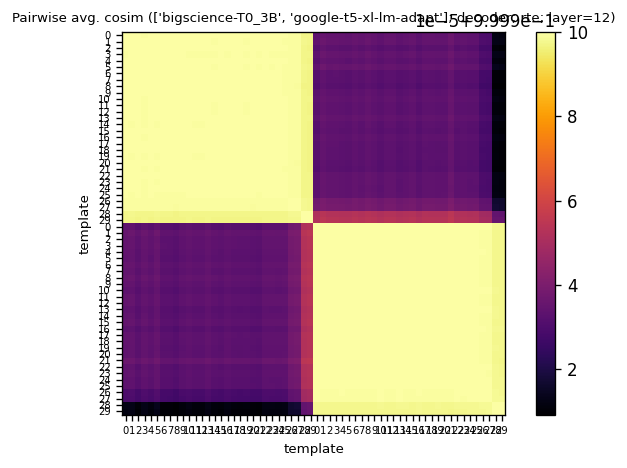

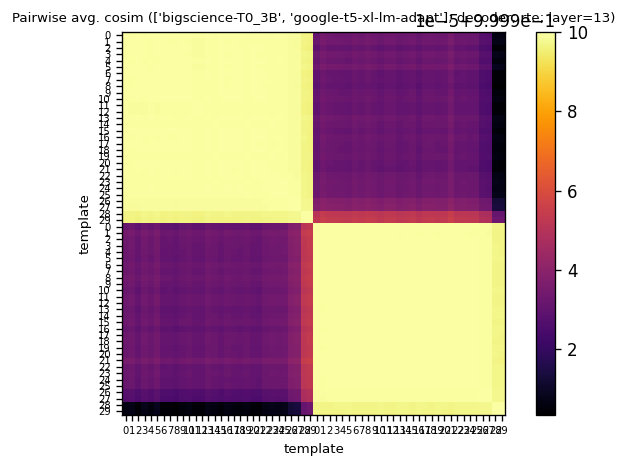

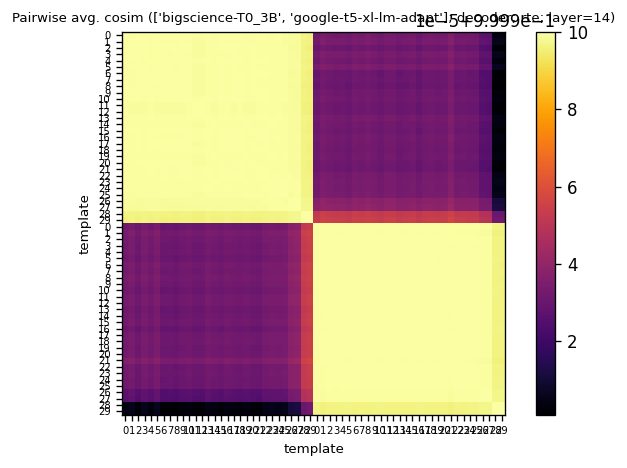

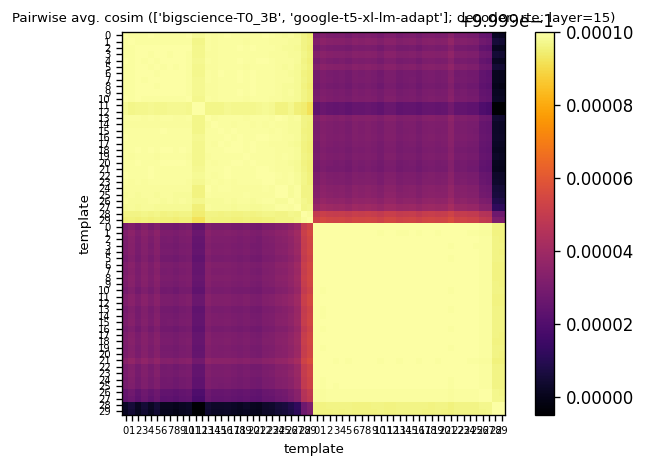

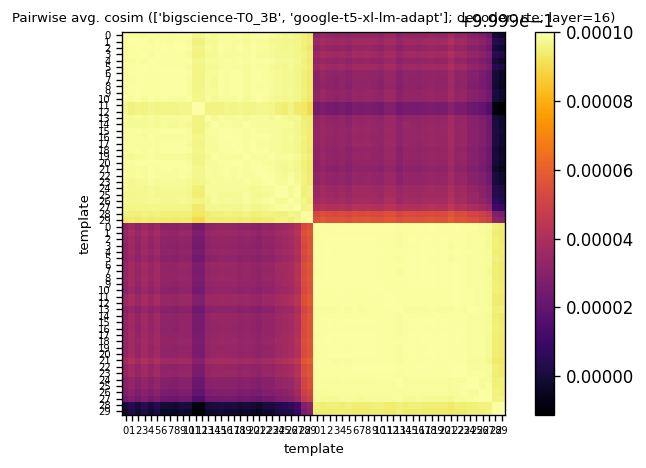

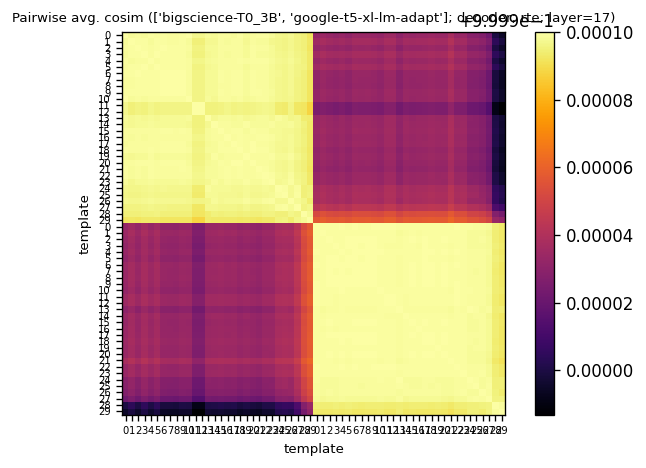

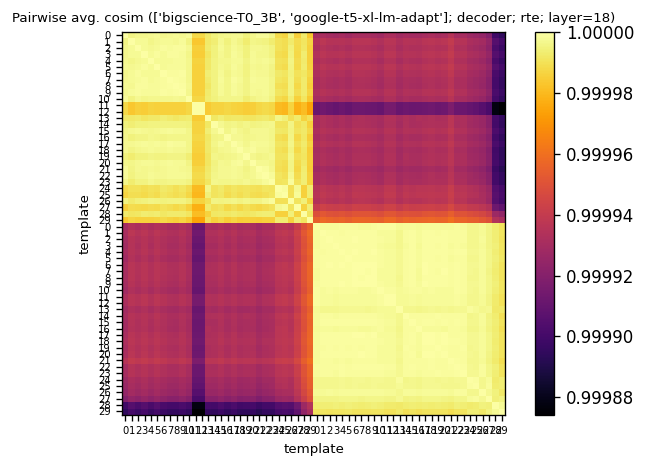

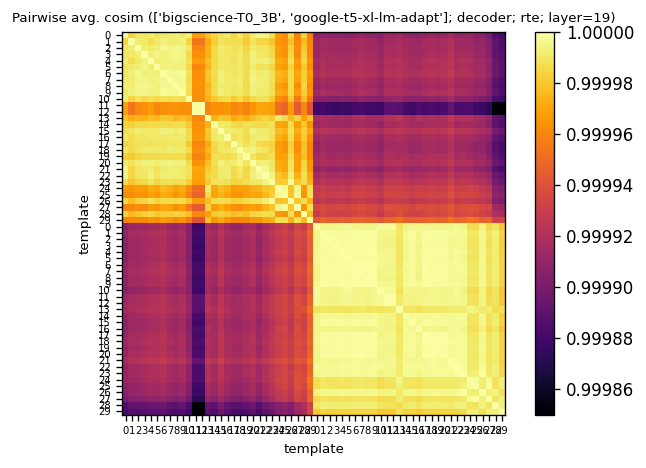

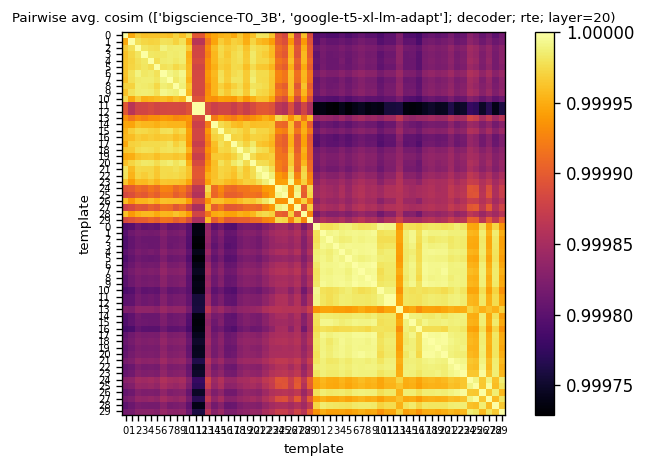

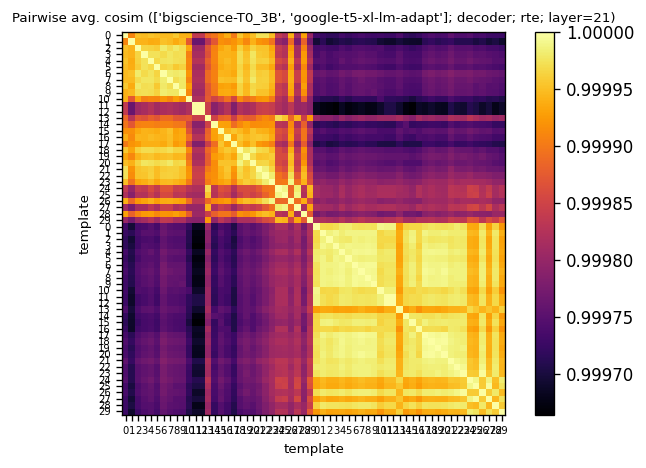

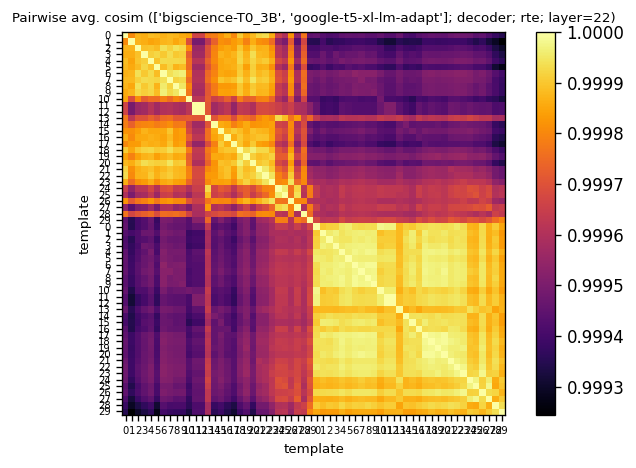

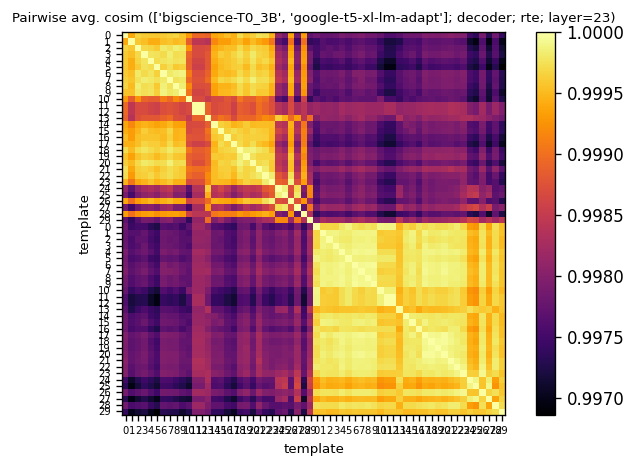

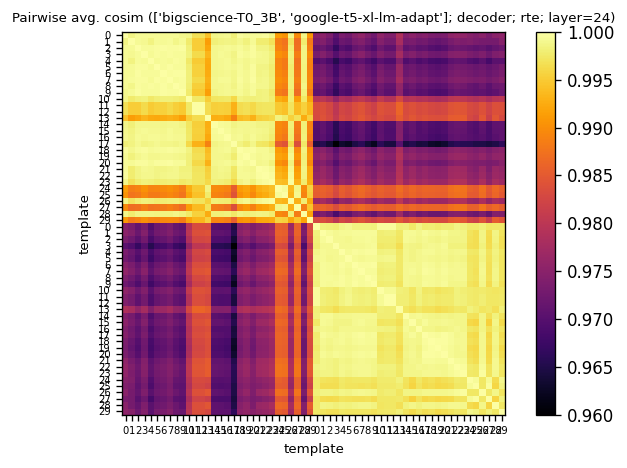

In [23]:
for l, layer_key in enumerate(cosim_scores_layers.keys()):
    values = cosim_scores_layers[layer_key]
    layer = layer_key.split('-')[-1]

    fig, axes = plt.subplots(1, 1, figsize=(5.5,4), dpi=120)

    im = axes.imshow(values, cmap='inferno', vmax=1.0)
    # Create colorbar
    cbar = axes.figure.colorbar(im, ax=axes)
    cbar.ax.set_ylabel("", rotation=-90, va="bottom")

    templates = list(range(len(use_pattern))) * 2
    axes.set_xlabel("template", fontsize=8)
    axes.set_xticks(range(len(templates)))
    axes.set_xticklabels(templates)

    axes.set_ylabel("template", fontsize=8)
    axes.set_yticks(range(len(templates)))
    axes.set_yticklabels(templates)

    plt.xticks(fontsize=6, rotation=0)
    plt.yticks(fontsize=6, rotation=0)

    axes.set_title(f"Pairwise avg. cosim ({models}; {module}; {task}; layer={layer})", fontsize=8)

    plt.tight_layout()
    plt.show()
    plt.close();


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


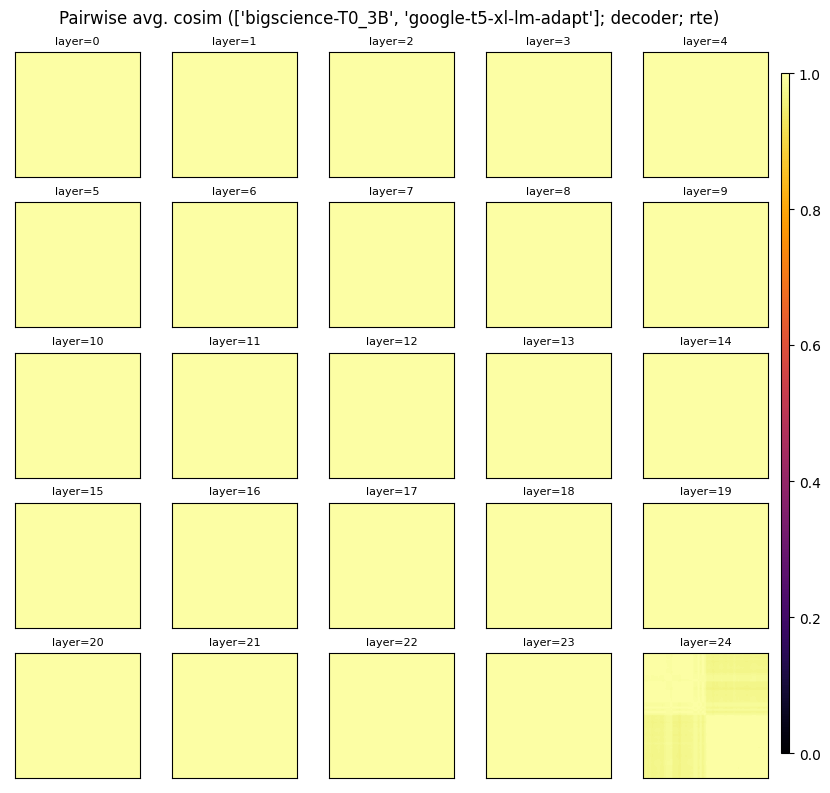

In [24]:
plt.figure(figsize=(8, 8), dpi=100)

for l, layer_key in enumerate(cosim_scores_layers.keys()):
    values = cosim_scores_layers[layer_key]
    layer = layer_key.split('-')[-1]

    plt.subplot(5, 5, l+1)
    axes = plt.gca()
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    im = axes.imshow(values, cmap='inferno', vmin=0.0, vmax=1.0)
    # Create colorbar
    # cbar = axes.figure.colorbar(im, ax=axes)
    # cbar.ax.set_ylabel("", rotation=-90, va="bottom")

    axes.set_xlabel("template", fontsize=8)
    axes.set_xticks(np.arange(len(values)))
    axes.set_ylabel("template", fontsize=8)
    axes.set_yticks(np.arange(len(values)))

    # axes.set_title(f"Pairwise CKA ({model}; {module}; {task}; layer={layer})", fontsize=8)
    axes.set_title(f"layer={layer}", fontsize=8)

# add colorbar
fig = plt.gcf()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.99, 0.05, 0.01, 0.85])
fig.colorbar(im, cax=cbar_ax)

plt.suptitle(f"Pairwise avg. cosim ({models}; {module}; {task})")
plt.tight_layout()
plt.show()
plt.close();

In [25]:
df

,name,template,category,includes_targets,targets,target_ids,shuffle
0,gpt_3_yes_no_with_targets,{premise} Question: {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
1,mnli_crowdsource_with_targets,"{premise} Using only the above description and what you know about the world, is ""{hypothesis}"" definitely correct? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
2,based_on_previous_passage_with_targets,"{premise} Based on the previous passage, is it true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
3,infer_with_targets,"Suppose {premise} Can we infer that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
4,follow_with_targets,Given that {premise} Does it follow that {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
5,imply_with_targets,"{premise} Question: Does this imply that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
6,guaranteed_with_targets,"Given {premise} Is it guaranteed true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
7,justified_with_targets,"{premise} Are we justified in saying that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
8,must_be_true_with_targets,"Given that {premise} Therefore, it must be true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
9,should_assume_with_targets,"Given {premise} Should we assume that ""{hypothesis}"" is true? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
